# Assignment large-sample hydrology: controls on streamflow signatures 

#### Wouter Berghuijs (w.r.berghuijs@vu.nl) & Ype van der Velde

In this Jupyter notebook you will work with a large hydrogical dataset called CAMELS (Newman et al. 2015). The dataset contains information for  671 small- to medium- sized catchments across the contiguous United States (median catchment size of 336 km$^2$) that span a  wide range of hydroclimatic conditions.  Daily streamflow data was compiled from the United States Geological Survey National Water Information System. The catchments are minimally impacted by human activities. The catchments have 20 years of daily streamflow data (expressed in mm/d). From these data several **streamflow signatures** are calculate (see Table below).

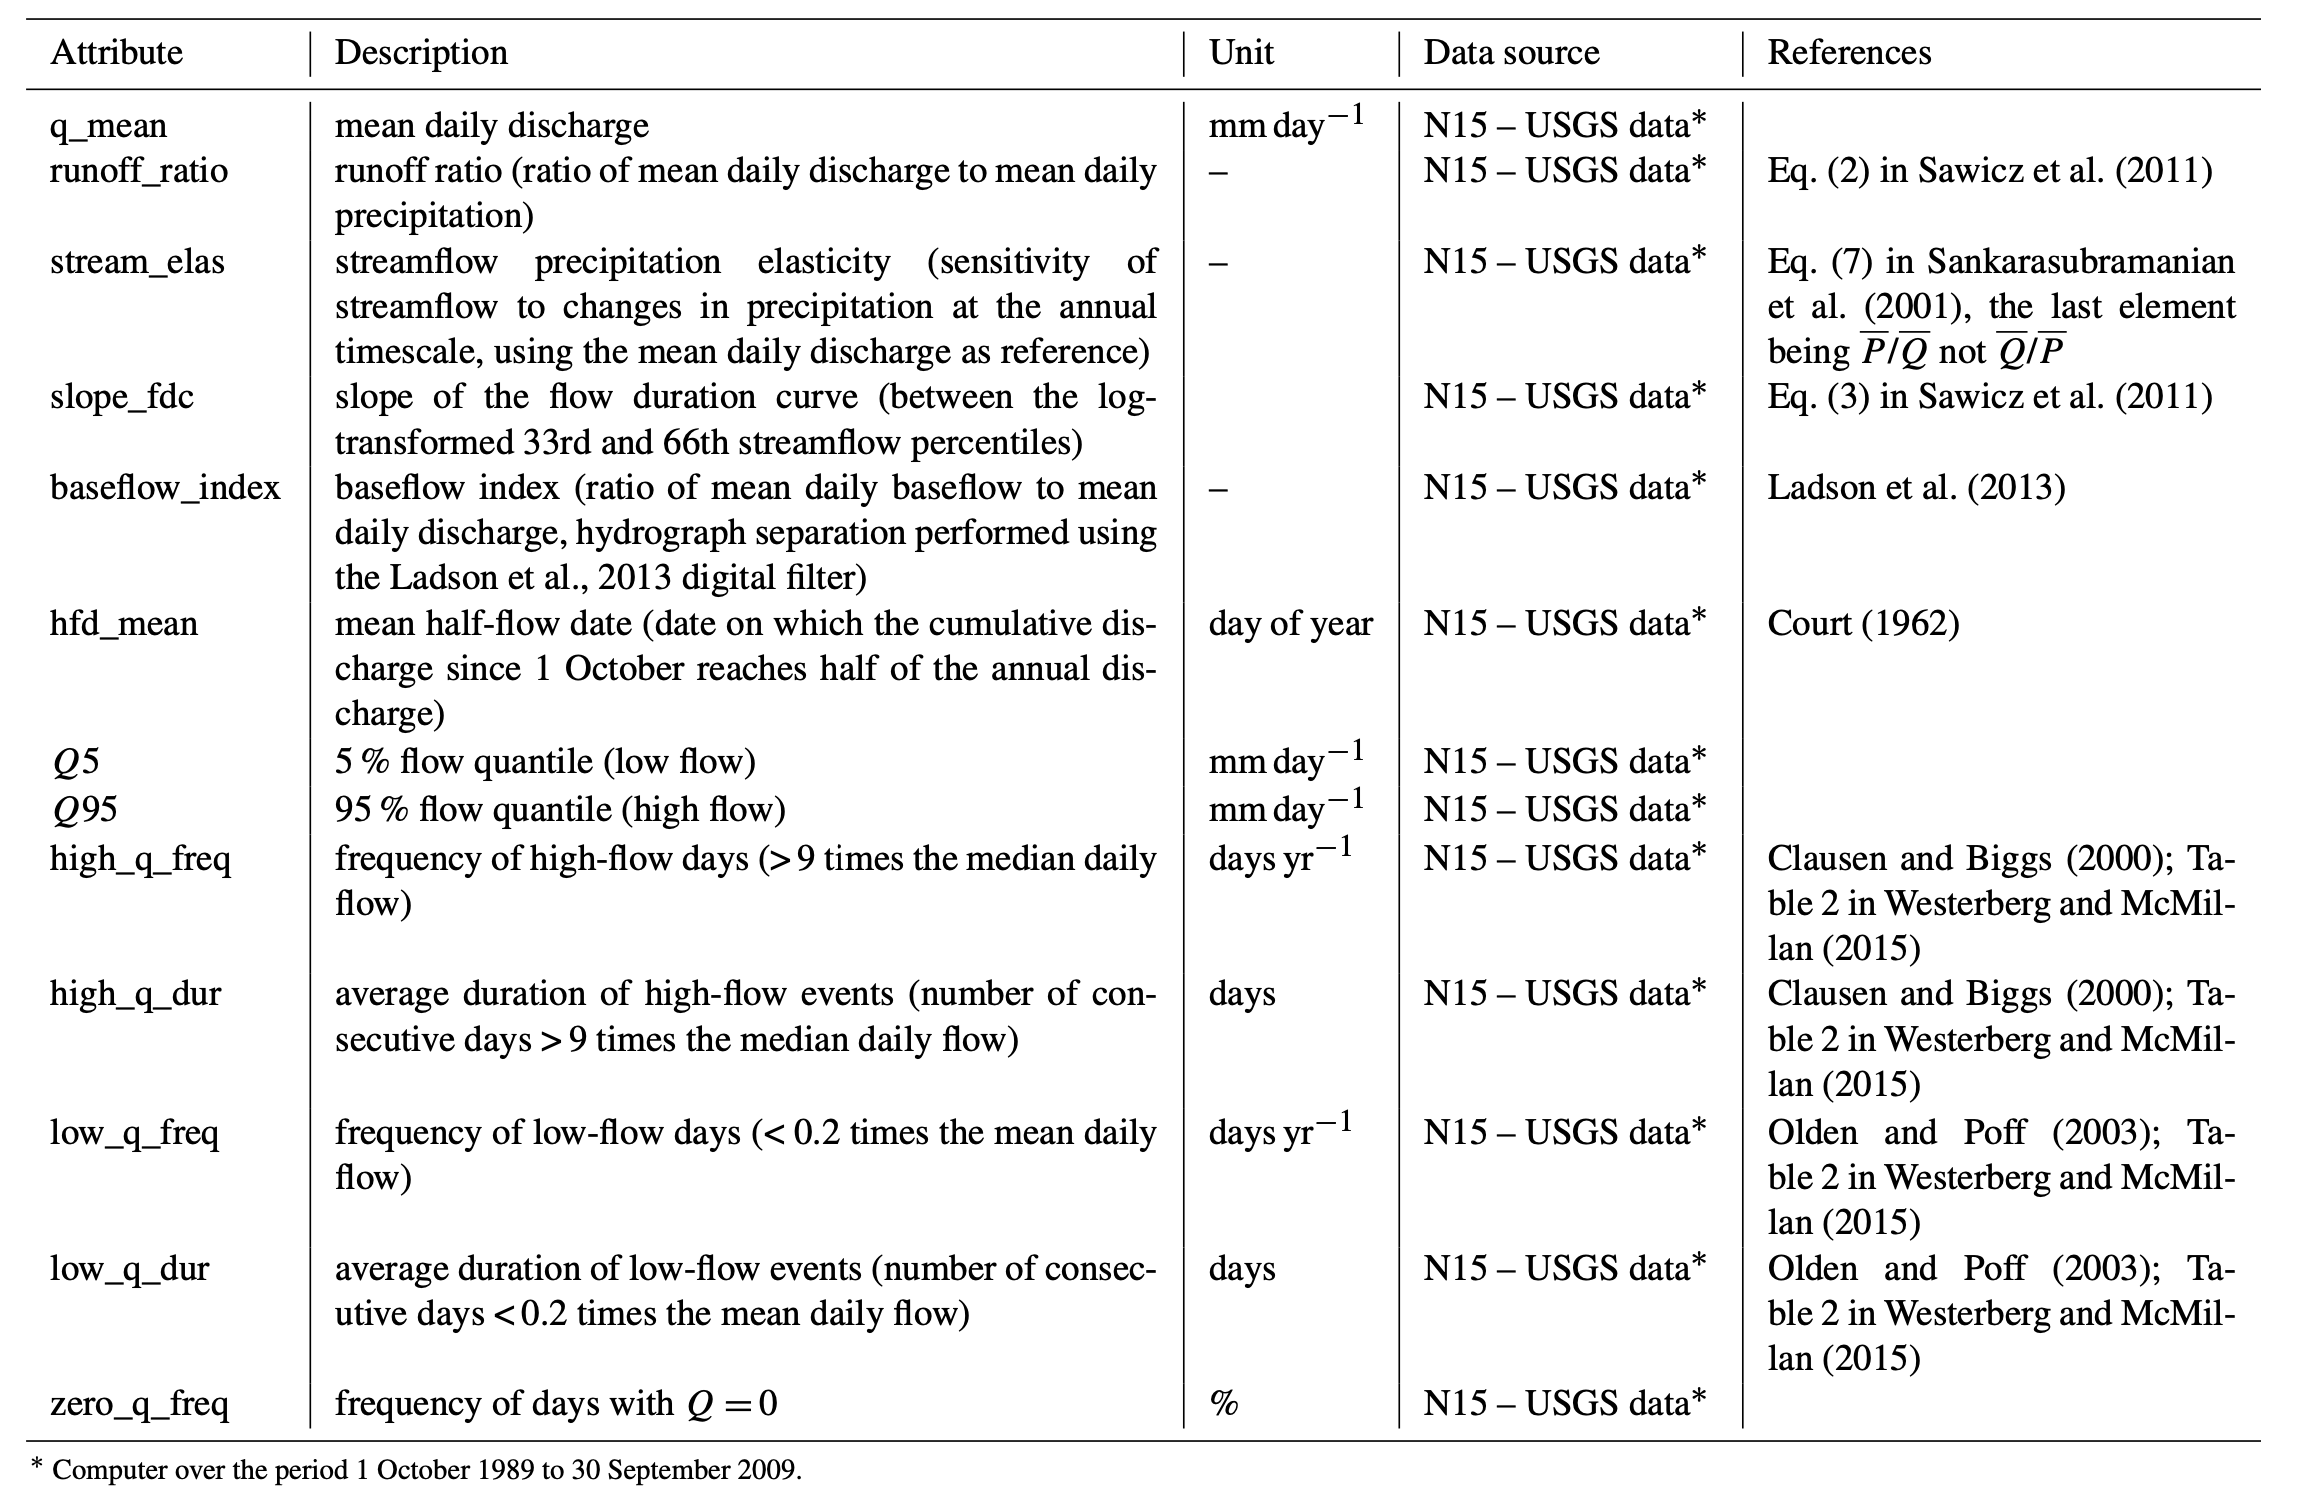

These streamflow signatures are quantitative indices that describe statistical or dynamical properties of streamflow. They can be useful in understanding how catchments behave, and how their behaviour varies between different catchments. In addition, their applications include extracting biologically relevant attributes of streamflow data, monitoring hydrologic change, analysing runoff generation processes, defining similarity between watersheds, and calibrating and evaluating hydrologic models. Hydrologic signatures allow  to extract meaningful information about catchment processes from streamflow series, and are therefore seeing increasing use in emerging information-rich areas such as global-scale hydrologic modelling, machine learning and large-sample hydrology. 

The CAMELS dataset also contains information about the climate and landscape of these catchments. The catchment propreties that are available span several classes: topography, climate, land cover, soil, and geology (see Addor et al., 2017: https://hess.copernicus.org/articles/21/5293/2017/) 


## Assignment

Your task in this assignment is to assess **which climate and landscape characteristics control between-catchment differences in streamflow signatures**. For details: see Canvas


## References
Addor, N., Newman, A. J., Mizukami, N., & Clark, M. P. (2017). The CAMELS data set: catchment attributes and meteorology for large-sample studies. Hydrology and Earth System Sciences, 21(10), 5293-5313.

Newman, A. J., Clark, M. P., Sampson, K., Wood, A., Hay, L. E., Bock, A., Viger, R. J., Blodgett, D., Brekke, L., Arnold, J. R., Hopson, T., and Duan, Q.: Development of a large-sample watershed-scale hydrometeorological data set for the contiguous USA: data set characteristics and assessment of regional variability in hydrologic model performance, Hydrol. Earth Syst. Sci., 19, 209–223, https://doi.org/10.5194/hess-19-209-2015, 2015.

In [1]:
# Import relevant packages and data

#make students do: conda env create -f frontiers_in.yml
# and activate conda env create -f environment.yml 

# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import geopandas
import ipywidgets as widgets
from collections import Counter
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

/Users/wbs211/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Read and merge CAMELS data
hydro = pd.read_csv('data/camels_hydro.txt', sep=";", header=0)
geo = pd.read_csv('data/camels_geol.txt', sep=";", header=0)
clim = pd.read_csv('data/camels_clim.txt', sep=";", header=0)
soil = pd.read_csv('data/camels_soil.txt', sep=";", header=0)
veg = pd.read_csv('data/camels_vege.txt', sep=";", header=0)
topo = pd.read_csv('data/camels_topo.txt', sep=";", header=0)
name =  pd.read_csv('data/camels_name.txt', sep=";", header=0)
frames = [hydro,soil, topo, clim, veg]
merged = pd.concat([hydro,soil, topo, clim, veg], axis=1)
hydro.reset_index(drop=True, inplace=True)
soil.reset_index(drop=True, inplace=True)
topo.reset_index(drop=True, inplace=True)
clim.reset_index(drop=True, inplace=True)
veg.reset_index(drop=True, inplace=True)
del merged['gauge_id']

# load shapefile USA
states = geopandas.read_file('shapefiles/usa-states-census-2014.shp')
plt.rcParams["figure.figsize"] = (12, 7)

In [3]:
## Plot a a histogram and calculate some statistics for a variable 

    # It allows you to pick the variable to display 
    # you can also choose the number of bins in the histrogram
    # For units and exact definitions, check the article of Newman et al. (2017)

def run_histogram(variable,bin_count):
    
    ## Python example
    X = merged[variable]
    fig = plt.figure(figsize =(5, 3))
    
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Creating plot
    plt.hist(X, bins=bin_count, alpha=0.5)
    
    # adding labels
    ax.set_xlabel(variable)
    ax.set_ylabel('Count')
    print(X.describe())
    plt.show()

# This makes the code interactive with the button you see below
widgets.interact(run_histogram,variable = merged, bin_count=(1,50,1))

interactive(children=(Dropdown(description='variable', options=('q_mean', 'runoff_ratio', 'slope_fdc', 'basefl…

<function __main__.run_histogram(variable, bin_count)>

In [4]:
## Make scatterplots of one variable against another 
    
    # This helps you test if one variable relates to another variable
    # You can pick what is displayn on the x-axis, the y-axis.
    # It also allows to pick a 3rd variable that will affect the color of each data point 
    # It also provides some statistics, 
    # namely the Spearman and Pearson correlation coefficients for x vs x, and associated p-values.
    
    # You can also fit a function through the data.

def run_scatter(variable_x,variable_y,variable_z,log_x_on,log_y_on,fit_function,polyfit):

    ## Python example
    X = merged[variable_x]
    Y = merged[variable_y]
    Z = merged[variable_z]

    fig = plt.figure(figsize =(5, 3))
    
    # Define color scheme
    cm=plt.get_cmap('turbo') 
    
    # You can pick another colorscale based on:  
    # https://matplotlib.org/stable/tutorials/colors/colormaps.html 
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Creating plot and adding labels
    sc = plt.scatter(X, Y,c=Z,  vmin=min(Z), vmax=max(Z),s=10, cmap=cm)
    ax.set_xlabel(variable_x)
    ax.set_ylabel(variable_y)
    cbar = plt.colorbar(sc)
    cbar.set_label(variable_z, rotation=270)
    new_X = X[np.logical_not(np.isnan(X*Y))]
    new_Y = Y[np.logical_not(np.isnan(X*Y))]
    
    # Fit function 
    linear_model=np.polyfit(new_X,new_Y,polyfit)
    linear_model_fn=np.poly1d(linear_model)
    
    if fit_function == "Yes":
        x_s=np.arange(min(X),max(X),(max(X)-min(X))/200)
        plt.plot(x_s,linear_model_fn(x_s),color="green")
        print(linear_model_fn)
    
    # Make axes logarithmic (if requested)
    if log_x_on =="Yes": 
        plt.xscale("log")
        
    if log_y_on =="Yes": 
        plt.yscale("log")
    
    # Show plot 
    plt.show()
    
    # Print statistics
    print('spearman')
    print(stats.spearmanr(new_X,new_Y))
    print('pearson')
    print(stats.pearsonr(new_X,new_Y))
    
# This makes the code interactive with the button you see below
widgets.interact(run_scatter,variable_x = merged,
                             variable_y = merged,
                             variable_z = merged,
                             log_x_on = ["No","Yes"],
                             log_y_on = ["No","Yes"],
                             fit_function = ["No","Yes"],
                             polyfit = [1, 2, 3, 4, 5, 6, 7, 8])

interactive(children=(Dropdown(description='variable_x', options=('q_mean', 'runoff_ratio', 'slope_fdc', 'base…

<function __main__.run_scatter(variable_x, variable_y, variable_z, log_x_on, log_y_on, fit_function, polyfit)>

In [5]:
# Make a map of a variable and adjust the upper and lower boundary of the colorscale

def map_maker(variable,min_fac,max_fac):
    plt.close()
    
    X = merged[variable]
    states.boundary.plot(color='black')
    cm=plt.get_cmap('jet') # choses color based on these options: https://matplotlib.org/stable/tutorials/colors/colormaps.html 
    sc = plt.scatter(topo.gauge_lon, topo.gauge_lat, c=X,  vmin=min(X)*min_fac, vmax=max(X)*max_fac, s=10, cmap=cm)
    cbar = plt.colorbar(sc, shrink=0.5)
    
    cbar.set_label(variable, rotation=270)
    plt.xlim(-127, -67)
    plt.ylim(24, 50)
    plt.show()

# This makes the code interactive with the button you see below
widgets.interact(map_maker,variable = merged,
                min_fac = (0,2,0.1), max_fac = (0,2,0.05))

interactive(children=(Dropdown(description='variable', options=('q_mean', 'runoff_ratio', 'slope_fdc', 'basefl…

<function __main__.map_maker(variable, min_fac, max_fac)>

In [6]:
# As a reference, a correlation matrix of everything against everything. 
# You can manually pick which correlation coefficient is presented in the graph

def correlation_overview(corr_type):
    corrmat = merged.corr(method= corr_type, min_periods = 1)
    f, ax = plt.subplots(figsize =(15, 13))
    sns.heatmap(corrmat, ax = ax, cmap ="BrBG", center=0, vmin=-1, vmax=1, linewidths = 0.1)

widgets.interact(correlation_overview, corr_type = ['pearson', 'kendall', 'spearman'])

interactive(children=(Dropdown(description='corr_type', options=('pearson', 'kendall', 'spearman'), value='pea…

<function __main__.correlation_overview(corr_type)>

In [8]:
## Here you can test if Machine Learning can build a predictive model of your streamflow signature. 
## The Machine Learning model we use is called RandomForestRegressor. 
## Many details of this model are not relevant for this assignment, but if you want to know more details you can consult: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
## The main (relevant) idea for this assignment is that the model test to what extent 3 predictor variables (of your own choice) manage to predict the streamflow signature of your choice.
## The model uses 80% of the data from training, and 20% for validation.
## The ability of the model to predict the signature can be inferred from graph that shows predicted signature vs the observed signature
## In addition the graph show the R-squared and Mean Squared Error of the predicted vs observed signature.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Let's make a predictive model based on a random forest model (where you select 3 predictor variables)
def regression_model(signature, variable1,variable2,variable3):
    y  = merged[signature]
    x1 = merged[variable1]
    x2 = merged[variable2]
    x3 = merged[variable3]
    Xs = pd.concat([y, x1, x2, x3], axis=1)
    Xs = Xs.dropna()
    y  = pd.DataFrame(Xs.iloc[:,0])
    X  =  pd.DataFrame(Xs.iloc[:, 1:4])
    
    # Split data into a part for training and for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
       
    # Run model
    rf = RandomForestRegressor(max_depth=3, random_state=10)
    rf.fit(X_train, y_train)
    y_rf_train_pred = rf.predict(X_train)
    y_rf_test_pred = rf.predict(X_test)

    # Evaluate performance
    rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
    rf_train_r2 = r2_score(y_train, y_rf_train_pred)
    
    rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
    rf_test_r2 = r2_score(y_test, y_rf_test_pred)
    
    # Print performance
    rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
    rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
    print(rf_results)
    # Make plot
    plt.figure(figsize=(5,5))
    plt.scatter(x=y_rf_test_pred, y=y_test, c="#7CAE00" ,alpha=0.3)
    plt.plot([min(y_rf_test_pred),max(y_rf_test_pred)], [min(y_rf_test_pred),max(y_rf_test_pred)], '--', color='grey')
    plt.text(0.05, 0.95, '--- 1:1-Line', transform=plt.gca().transAxes, va='top', ha='left', color='grey')
    plt.ylabel('Predicted Signature Value')
    plt.xlabel('Observed Signature Value')

widgets.interact(regression_model,signature = merged, variable1 = merged,variable2 = merged,variable3 = merged)

interactive(children=(Dropdown(description='signature', options=('q_mean', 'runoff_ratio', 'slope_fdc', 'basef…

<function __main__.regression_model(signature, variable1, variable2, variable3)>